In [1]:
%load_ext autoreload
%autoreload 2

import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm import tqdm

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]

# fix gpu memory management 
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

# enable reproducibility
SEED = 42
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Loading and normalizing the dataset

In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0

# Visualizing some samples

In [3]:
def preview(size):
    labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    fig, ax = plt.subplots(size, size)
    for i in range(size):
        for j in range(size):
            idx = np.random.choice(len(x_train))
            ax[i, j].imshow(x_train[idx])
            ax[i, j].axis('off')
            ax[i, j].set(title=labels[y_train[idx, 0]])

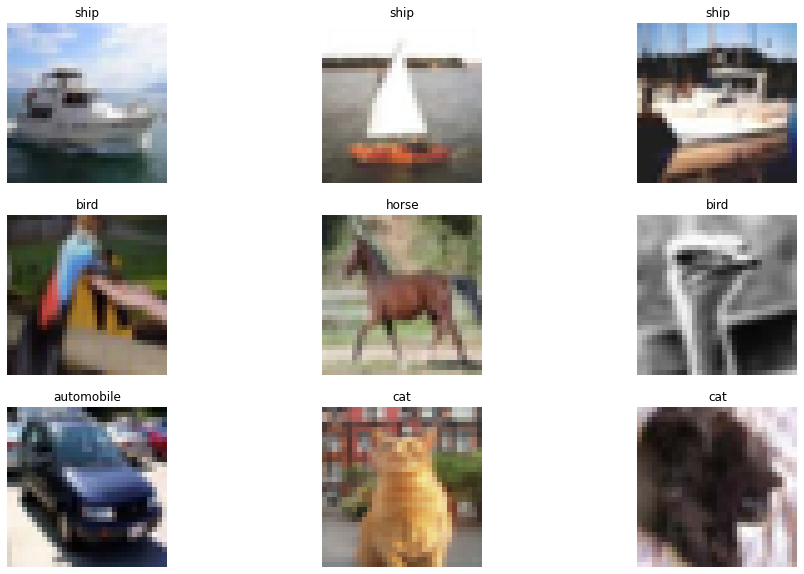

In [4]:
preview(3)

In [5]:
from src.model import SimpleNet
from src.signature import Signature

model = SimpleNet()

signature_length = int(model.count_params() * 1e-4)
sig = Signature(b'Some block information', signature_length)
other_sig = Signature(b"Some other block information", signature_length)
yet_another_sig = Signature(b"Some other block information", signature_length)

In [6]:
train_parameters = {
    'steps_per_epoch' : None,
    'epochs' : 50,
    'validation_data' : (x_test,y_test),
    'batch_size' : 100
}

TRAINING = False
SAVING = False
MODEL_NAME = '50epochs_baseline'

if TRAINING:
    model.fit(x_train, y_train, **train_parameters)
if SAVING:
    model.save_weights(f'models/{MODEL_NAME}/model')
    model.save_training_plot(f'img/{MODEL_NAME}.svg')
    model.save_training_history(f'training_history/{MODEL_NAME}.csv')

In [7]:
f = lambda x : "Verified" if x else "Not verified"
print(f"Checking model against original signature : {f(sig.verify(model))}")
print(f"Checking model against another signature : {f(other_sig.verify(model))}")

Checking model against original signature : Not verified
Checking model against another signature : Not verified


In [8]:
def signature_hit(baseline):
    hit = {
        'signature_size' : [],
        'model_ratio' : [],
        'accuracy' : [],
    }
    
    model_ratio = np.linspace(0, 0.1, 50)
    model = SimpleNet()

    for ratio in tqdm(model_ratio):
        sig_size = int(ratio*model.n_weights())
        signature = Signature(b'Some block information', sig_size)
        model.load_weights(baseline).expect_partial()
        signature.sign(model)
        assert signature.verify(model)
        result = model.evaluate(x_test, y_test, verbose=0)
        hit['model_ratio'].append(ratio)  
        hit["signature_size"].append(sig_size)
        hit['accuracy'].append(result[1])
        
    return hit

In [9]:
from scipy.optimize import least_squares

def decay(t, a, b, c):
    return  a + b * np.exp(t * c)

def fun(x, t, y):
    return x[0] + x[1] * np.exp(x[2] * t) - y

def fit_hit(data):
    x = np.linspace(0, 0.1, 100, dtype='float64')
    trn = np.array(data["model_ratio"])
    tst = np.array(data["accuracy"])
    x0 = np.array([1.0, 1.0, 0.0])
    sol = least_squares(fun, x0, loss='soft_l1', args=(trn, tst)).x

    fig, ax = plt.subplots()
    ax.scatter(metrics["model_ratio"], metrics["accuracy"], label='Accuracy on test set')
    ax.plot(x, decay(x, *sol), label=f'{sol[0]:.1} + {sol[1]:.1} $e^{{{sol[2]:.0f}r}}$')
    ax.set(xlabel='Signature size / # of model parameters', ylabel='Accuracy', title="Pretrained model accuracy after applying signature")
    ax.legend(loc="upper right")
    
    return fig

100%|██████████| 50/50 [01:04<00:00,  1.30s/it]


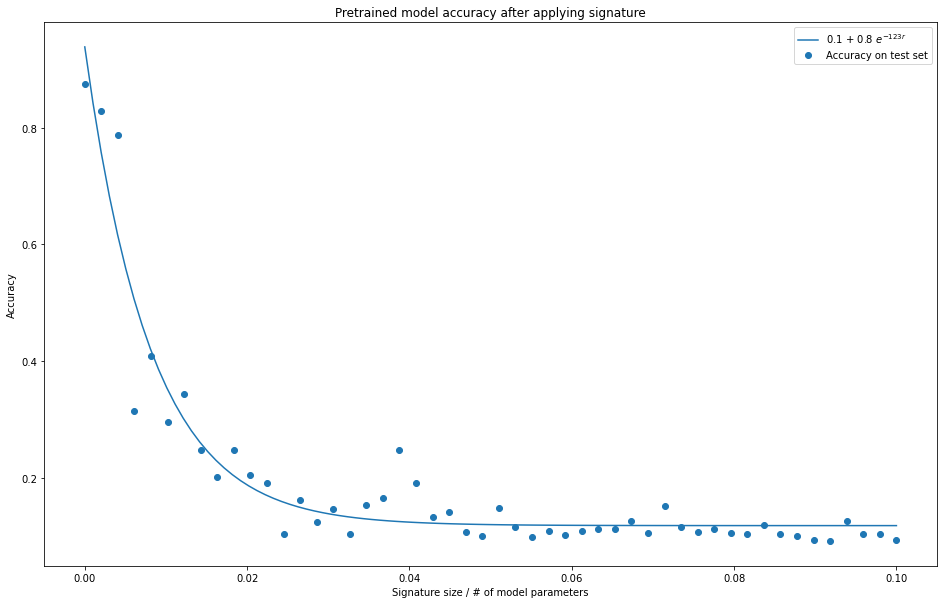

In [10]:
metrics = signature_hit(f'models/{MODEL_NAME}/model')
fig = fit_hit(metrics)
pd.DataFrame(metrics).to_csv(f'signature_hit/{MODEL_NAME}.csv')
fig.savefig(f'signature_hit/{MODEL_NAME}.svg')